In [1]:
import os
from sys import exit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, concatenate, Dense,TimeDistributed, Dropout, Bidirectional
import keras
#from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from keras.utils import Sequence
from keras.utils import to_categorical
from seqeval.metrics import (classification_report, f1_score, precision_score, recall_score, accuracy_score)
from nltk.tokenize import RegexpTokenizer
import re
import string
from nltk.stem import WordNetLemmatizer

Using TensorFlow backend.


In [2]:
# set working directory as ''
# import text
print("Current working directory", os.getcwd())
try:
    # Change the current working Directory    
    os.chdir("C:\\Users\\Ethan\\Desktop\\Codetest")
    print("Directory changed")
except OSError:
    print("Can't change the Current Working Directory") 
    
text_dir = 'news_tagged_data.txt'
word2vec_dir = 'wordvecs.txt'
with open(text_dir, 'r') as f:
    text = f.read()
f.close()

words = []
tags = []
for st in text.split('\n'):
    try:
        tags.append(st.split("\t")[1])
        words.append(st.split("\t")[0])
    except IndexError:
        tags.append('O')
        words.append('padword')
        pass

Current working directory C:\Users\Ethan
Directory changed


In [3]:
# check corpus and tags, create dictionaries of tag2num and num2tag
corpus = list(set(words))
n_tags = list(set(tags))

tag2num = dict([tag, i] for i, tag in enumerate(n_tags))
num2tag = dict([i, tag] for i, tag in enumerate(n_tags))

print("{:} words in the text".format(len(corpus)))
print("{:} types of tags".format(len(n_tags)))

1437 words in the text
9 types of tags


In [4]:
# get tokens of sentence and convert labels to numbers
def form_sentences(word_list, tag_list):
    sentences = [[]]
    sen_tag = [[]]
    last = len(word_list) - 1    
    for i, (w, t) in enumerate(zip(word_list, tag_list)):
        if w == "padword":
            sentences[-1].append("padword")
            sen_tag[-1].append(tag2num["O"])
            if i != last:
                sentences.append([])
                sen_tag.append([])
        else:
            sentences[-1].append(w)
            sen_tag[-1].append(tag2num[t])
    return sentences, sen_tag
sentences, sen_tag = form_sentences(words, tags)
sentences[10]

['spotlight',
 'news',
 'that',
 's',
 'centered',
 'around',
 'a',
 'fire',
 'padword']

In [5]:
sen_tag[10]

[6, 7, 0, 0, 0, 0, 0, 5, 0]

The longest sentence contains 30 words


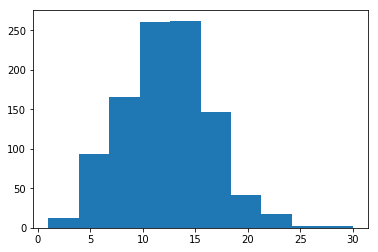

In [6]:
# get the distribution of sentences length
sen_lengths = [len(sen) for sen in sentences]
plt.hist(sen_lengths)
print("The longest sentence contains {:} words".format(np.max(sen_lengths)))

In [7]:
# I'll choose the 95 percentile of sentence length vector as max_len for sequence padding
# and fill empty space with 'padword' and label 'O' in sentences, sen_tag, respectively
max_len = int(np.percentile(sen_lengths, 95))
def fill_padword(sequences, max_length, pad):
    for i, seq in enumerate(sequences):
        if len(seq) < max_length:
            add_pad = [pad] * (max_length - len(seq))
            sequences[i] = seq + add_pad
        else:
            sequences[i] = seq[:max_length]
    return sequences

sentences = fill_padword(sentences, max_len, "padword")
sen_tag = fill_padword(sen_tag, max_len, tag2num["O"])            
sentences[10]

['spotlight',
 'news',
 'that',
 's',
 'centered',
 'around',
 'a',
 'fire',
 'padword',
 'padword',
 'padword',
 'padword',
 'padword',
 'padword',
 'padword',
 'padword',
 'padword',
 'padword',
 'padword']

In [8]:
sen_tag[10]

[6, 7, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [9]:
# One hot encoding for labels (1001, 30) -> (1001, 30, 9)
y = np.array(sen_tag)
y = [to_categorical(i, num_classes= len(n_tags)) for i in y]

In [10]:
# convert sequences of words into sequences of numbers, each number corresponds to a word in corpus
corpus2num = dict([word, i] for i, word in enumerate(corpus))
def seqword2seqnum(sequence, word2num):
    for i, word in enumerate(sequence):
        sequence[i] = word2num[word]
    return sequence
sentences = [seqword2seqnum(sequence, corpus2num) for sequence in sentences]
sentences = np.array(sentences)
#sen_tag = np.array(sen_tag)
sentences[10]

array([ 777,  739,  698,  830,  532,  389,  684,  929, 1208, 1208, 1208,
       1208, 1208, 1208, 1208, 1208, 1208, 1208, 1208])

In [11]:
# use word2vec file for embedding for words in corpus
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype = 'float32')
embedding = dict(get_coefs(*o.strip().split("\t")) for o in 
                 open(word2vec_dir, encoding = 'utf-8', errors ='ignore').read().split('\n'))

dimension = 300
embedding.pop('') # drop key ''
mean = np.stack(embedding.values(), axis = 1).mean()
std = np.stack(embedding.values(), axis =1).std()
embed_weights = np.random.normal(mean, std, size = (len(corpus), dimension))

for word, i in corpus2num.items():
    if embedding.get(word) is not None:
        embed_weights[i] = embedding.get(word)
 

In [12]:
# split the data into training 90% and test 10%.
train_X, test_X, train_y, test_y = train_test_split(sentences, np.array(y), test_size = 0.1) 

In [13]:
#build training and validation generator 
 
class DataGenerator(Sequence):
    def __init__(self, sentences, y, batch_size = 16, shuffle = True, num_class = 10):
        self.sentences = sentences
        self.y = y
        self.batch_size = batch_size
        #self.dim = dim
        self.num_class = num_class
        self.shuffle = shuffle
        self.shuffle_indexes()
    def shuffle_indexes(self):
        self.indexes = np.arange(len(self.y))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    def __len__(self):
        return int(np.ceil(len(self.y) / self.batch_size))
    def __getitem__(self, index):
        ind = self.indexes[(index*self.batch_size) : np.min([(index+1)*self.batch_size, len(self.y)])] 
        data = [self.sentences[i] for i in ind]
        label = [self.y[i] for i in ind]
        #y = to_categorical(y, num_classes = self.num_class)
        return np.array(data), np.array(label).astype('int32')


In [14]:
parameters = {'batch_size': 16,
              'shuffle': True,
              'num_class': len(n_tags)}
train_generator = DataGenerator(train_X, train_y,**parameters)
validation_generator = DataGenerator(test_X, test_y,**parameters)
#generator.__getitem__(62)
print("{:} batchs of data in training generator".format(train_generator.__len__()))

57 batchs of data in training generator


In [15]:
# now onto neural network architecture
def build_model(unit1 = 128, unit2 = 128, recurrent_dropout = 0.1, dropout = 0.1, epochs = 5, filepath = "best_model.h5"):
    
    callback_list = [keras.callbacks.EarlyStopping(monitor = 'val_acc', patience = 2), 
                     keras.callbacks.ModelCheckpoint(filepath = filepath, monitor = 'val_acc',
                                                     save_best_only = True)]
    input_ = Input(shape=(max_len,))
    embedding = Embedding(len(corpus), dimension, weights = [embed_weights], trainable = False)(input_)
    x = Bidirectional(LSTM(units = unit1, return_sequences=True,
                           recurrent_dropout= recurrent_dropout, dropout = dropout))(embedding)
    x_rnn = Bidirectional(LSTM(units = unit2, return_sequences=True,
                               recurrent_dropout = recurrent_dropout, dropout = dropout))(x)
    x = concatenate([x, x_rnn])  # residual connection to the first biLSTM
    output_ = TimeDistributed(Dense(len(n_tags), activation="softmax"))(x)
    model = Model(input_, output_)
    
    model.summary()
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    
    model.fit_generator(train_generator, 
                        epochs = epochs, 
                        steps_per_epoch = len(train_generator),
                        validation_data = validation_generator,
                        validation_steps = len(validation_generator),
                        callbacks = callback_list
                        )
    model.load_weights(filepath)
    return model

In [16]:
model = build_model(unit1 = 512, unit2 = 512, recurrent_dropout = 0.2, dropout = 0.2, epochs = 5)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 19)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 19, 300)      431100      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 19, 1024)     3330048     embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 19, 1024)     6295552     bidirectional_1[0][0]            
__________________________________________________________________________________________________
concatenat

In [17]:
# Evaluate model by inspecting following measures: precision, recall, f1
val_pred = model.predict(test_X, batch_size = 16)
def pred2label(pred):
    labels = []
    for sentence in pred:
        label = []
        for word in sentence:
            index = np.argmax(word, axis = -1)
            label.append(num2tag[index])
        labels.append(label)
    return labels
pred_labels = pred2label(val_pred)
true_labels = pred2label(test_y)

def evaluate(y_true, y_pred):
    print("accuracy: {:.2}".format(accuracy_score(y_true, y_pred)))
    print("precision: {:.2}".format(precision_score(y_true, y_pred)))
    print("recall: {:.2}".format(recall_score(y_true, y_pred)))
    print("f1: {:.2}".format(f1_score(y_true, y_pred)))
    print(classification_report(y_true, y_pred))

evaluate(true_labels, pred_labels)

accuracy: 0.99
precision: 0.9
recall: 0.94
f1: 0.92
             precision    recall  f1-score   support

   NEWSTYPE       1.00      1.00      1.00        74
   PROVIDER       0.88      0.95      0.91        56
   KEYWORDS       0.84      0.90      0.87        77
    SECTION       0.87      0.81      0.84        16

avg / total       0.91      0.94      0.92       223



In [ ]:
'''Predict IOB tags for new queries'''

In [36]:
def get_tokens(query):
    return re.findall("[\w']+|[!#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]", query.lower())

def out_domain_tokens(tokens):
    out_domain = []
    for word in tokens:
        if word.lower() not in corpus:
            out_domain.append(word)
    return list(set(out_domain))

#out_domain_tokens(text)

# break query at characters of ',' and '.'
def form_subquery(tokens):

    period_ind = [i for i, token in enumerate(tokens) if token=='.']
    comma_ind = [i for i, token in enumerate(tokens) if token==',']
    period_ind.extend(comma_ind)
    breaks = sorted(period_ind)
    sub_queries = [" ".join(tokens[i : j]).replace('.','').replace(',','').strip() 
                   for i, j in zip([0] + breaks, breaks + [None])]
    if '' in sub_queries:
        sub_queries.remove("")
    return sub_queries

# remove words out of new domain from these sub-queries
def remove_out_domain(subs, out_domain):
    for i, sub in enumerate(subs):
        sub_seq = sub.split()
        for sub_word in sub.split():
           if sub_word in out_domain:
               sub_seq.remove(sub_word)
        subs[i] = " ".join(sub_seq)
    return subs

In [37]:
# now lets deal with long subquery: those whose number of words excced max_len
def long_query(queries, max_length, back = 5, sentence = True):
    copy = []
    cut = []
    for query in queries:
        
        if len(query.split()) <= max_length:
            if sentence:
                copy.append(query)
            else:
                copy.append(query.split())
            cut.append((0, len(query.split())))
     
        else:
            querylen = len(query.split())
            end = max_length
            cut.append((0,end)) 
            while end <= querylen:
                if sentence:
                    sub = " ".join(query.split()[end - max_length : end])
                else:
                    sub = query.split()[end - max_length : end]
                copy.append(sub)
                end = end + max_length - back
                if end <= querylen:
                    cut.append((back, None))
                
            if sentence: 
                sub = " ".join(query.split()[end - max_length : ])
            else:
                sub = query.split()[end - max_length : ]
            
            copy.append(sub)
            cut.append((back, querylen + max_length - end))

    return copy, cut

In [38]:
# an example of dealing with long queries
sample = 'crimean bissau @kingsport %annarborcom  dr sicilia, mbabane smith huron kingston < paul boni island ! agritech whale eruption# windsor with 360 kate táº¥n turkey. beckinsale oskaloosa poliomyelitis burns international queen chile kokhir junta next reporter verde breeze huston comics freescale vienna cultural hemsworth hamilton park microsoft smoky mediterranean tobago el flood canadian. pettyfer tire blizzard brownwood community aquion eccentric gaceta nursultan californian poughkeepsie fever daviÃ° state brazil lapaglia noumea brightsource appeal wave savarin far film haider redford crier guatemala rockslide higgins holly tunisia serbia rica electronics missoulian fairfield sopoaga. brand samoa lance rooney livonia wyle austin typhus, technologies liechtenstein glendale israel browne.'
tokens = get_tokens(sample)        
out_domain = out_domain_tokens(tokens)  

In [39]:
# cut query into sentences based on the appearance of ',' and '.'
subs = form_subquery(tokens)
subs

['crimean bissau @ kingsport % annarborcom dr sicilia',
 'mbabane smith huron kingston < paul boni island ! agritech whale eruption # windsor with 360 kate táº n turkey',
 'beckinsale oskaloosa poliomyelitis burns international queen chile kokhir junta next reporter verde breeze huston comics freescale vienna cultural hemsworth hamilton park microsoft smoky mediterranean tobago el flood canadian',
 'pettyfer tire blizzard brownwood community aquion eccentric gaceta nursultan californian poughkeepsie fever daviã state brazil lapaglia noumea brightsource appeal wave savarin far film haider redford crier guatemala rockslide higgins holly tunisia serbia rica electronics missoulian fairfield sopoaga',
 'brand samoa lance rooney livonia wyle austin typhus',
 'technologies liechtenstein glendale israel browne']

In [40]:
# remove tokens from sentences, and break sentences longer than maxlen into sub-sentences
maxlen = 19
clean_subs = remove_out_domain(subs, out_domain)
break_subs, cut = long_query(clean_subs, max_length = maxlen, sentence = True) 
break_subs

['crimean bissau kingsport annarborcom dr sicilia',
 'mbabane smith huron kingston paul boni island agritech whale eruption windsor with 360 kate n turkey',
 'beckinsale oskaloosa poliomyelitis burns international queen chile kokhir junta next reporter verde breeze huston comics freescale vienna cultural hemsworth',
 'comics freescale vienna cultural hemsworth hamilton park microsoft smoky mediterranean tobago el flood canadian',
 'pettyfer tire blizzard brownwood community aquion eccentric gaceta nursultan californian poughkeepsie fever state brazil lapaglia noumea brightsource appeal wave',
 'lapaglia noumea brightsource appeal wave savarin far film haider redford crier guatemala rockslide higgins holly tunisia serbia rica electronics',
 'holly tunisia serbia rica electronics missoulian fairfield sopoaga',
 'brand samoa lance rooney livonia wyle austin typhus',
 'technologies liechtenstein glendale israel browne']

In [41]:
def display(prediction):

        print("\n")
        print(29 * '-')
        print("{:15} | {:}".format("Word", "Pred_label"))
        print(29 * '-')
        for i, word, pre in prediction:
            print("{:15} | {:}".format(word, pre))

In [42]:
def main(query, maxlen):
    
    tokens = get_tokens(query)        
    out_domain = out_domain_tokens(tokens) 
    subs = form_subquery(tokens)
    
    clean_subs = remove_out_domain(subs, out_domain)
    break_subs, cut = long_query(clean_subs, max_length = maxlen, sentence = False)    
    
    sent = fill_padword(break_subs, maxlen, "padword")
    sent = [seqword2seqnum(sequence, corpus2num) for sequence in sent]

    A_pred = model.predict(np.array(sent), batch_size = 1)
    A_tag = [[num2tag[i] for i in index] for index in np.argmax(A_pred, axis = -1)]
    
    align = []
    for sub, t in zip(A_tag, cut):
        align += sub[t[0]:t[1]]
    
    token2tag = [(token, 'O') if token in out_domain else (token, '') for token in tokens]
    
    in_do = []
    out_do = []
    j = 0
    for i, t in enumerate(token2tag):
    
        if t[0] in out_domain:
            out_do.append((i, t[0], t[1]))
        else:
            in_do.append((i, t[0], align[j]))
            j += 1    
    
    final = in_do + out_do
    final.sort()
    
    #sentence = "windsor central bank would want sports a commercial outlook"
    
    display(final) 

In [53]:
main("I want to travel $ %around the# world from a Canadian city to New York view financial company. From New York, I travel west to visit my sports star in Philadelphia and watch a Rock show then take a train to west coast to enjoy the pacific weather", max_len)



-----------------------------
Word            | Pred_label
-----------------------------
i               | O
want            | O
to              | O
travel          | O
$               | O
%               | O
around          | O
the             | O
#               | O
world           | B-KEYWORDS
from            | O
a               | O
canadian        | B-PROVIDER
city            | I-PROVIDER
to              | O
new             | O
york            | I-PROVIDER
view            | O
financial       | I-KEYWORDS
company         | I-KEYWORDS
.               | O
from            | O
new             | B-PROVIDER
york            | I-PROVIDER
,               | O
i               | O
travel          | I-KEYWORDS
west            | I-KEYWORDS
to              | O
visit           | O
my              | O
sports          | B-PROVIDER
star            | I-PROVIDER
in              | O
philadelphia    | B-PROVIDER
and             | I-PROVIDER
watch           | O
a               | O
rock            | B-PRO